Assignment 4 (Due: Sunday, May 26, 2024)

The devised program estimates robustly, given very noisy and very sparse data of infected and recovered of a past epidemic, the basic reproduction number of the SIR model. To keep computation in limit, we assume gamma=1. The SIR model is implemented in a minimal and optimal way, using scaled variables and a scaled time. Only the ODE part is numerically integrated that needs to be integrated. The noisy number of infected and the number of recovered are highly correlated. This relationship helps MCMC infer the parameters. 

Get familiar with the commented MCMC code below.

Task:
Change the program to the SIRD model, by including (D)eaths, with rate $\mu$. Fix not only $\gamma=1$ but also $\beta=2.5$ (or to a higher value of your choice). 
Infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.
If you want, you can try to optimze the code (optional, very very hard). 
Also optional is: Does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given ?
You may use these (initial) conditions/parameters: $$i0 = 0.01, s0 = 0.99, r0 = 0, d0 = 0, f = 3.0, timestep = 0.5.$$
You may assume values for the respective $\sigma$'s (log-normal noises) in the range of $0.2-0.4$, but not lower than $0.1$. For assessment use HPD plots, or similar. Good luck and have fun.

## Design the SIRD model 
we use gamma = 1, beta = 2.5, mu = 0.1 to establish our SIRD model. 
The SIRD is solved by scipy integrate odeint.

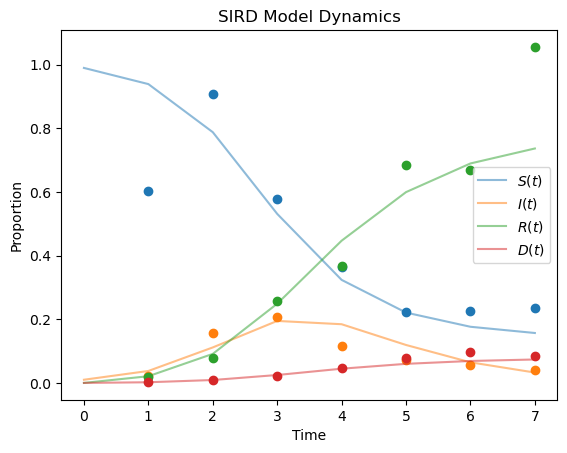

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from pymc.ode import DifferentialEquation
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
import arviz as az

# Define initial conditions of SIRD model
i0 = 0.01  # fractions infected at time t0=0 (1%)
r0 = 0.00  # fraction of recovered at time t0=0
d0 = 0.00  # fraction of deceased at time t0=0
f = 1.5  # 3.0 # time factor, defines total time window range

timestep_data = 1  # dt for data (e.g., weekly)

# ODE SIRD system, parameters p[0]=beta, p[1]=gamma, p[2]=mu
def SIRD(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1] - p[2] * y[1]
    dr = p[1] * y[1]
    dd = p[2] * y[1]
    return [ds, di, dr, dd]

times = np.arange(0, 5 * f, timestep_data)

# ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5
gamma = 1
mu = 0.1  # death rate

# Create SIRD curves
y0 = [1 - i0 - r0 - d0, i0, r0, d0]
y = odeint(SIRD, y0, times, args=([beta, gamma, mu],), rtol=1e-8)

# Observational model for multiplicative noise
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.60, 0.20, 0.20])  # noise is multiplicative (makes sense here)

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:, 2], color='C2', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:, 3], color='C3', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.title('SIRD Model Dynamics')
plt.show()



## MCMC process

Output()

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, R0, gamma, mu]


Output()

Sampling 8 chains for 1_000 tune and 200 draw iterations (8_000 + 1_600 draws total) took 6467 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


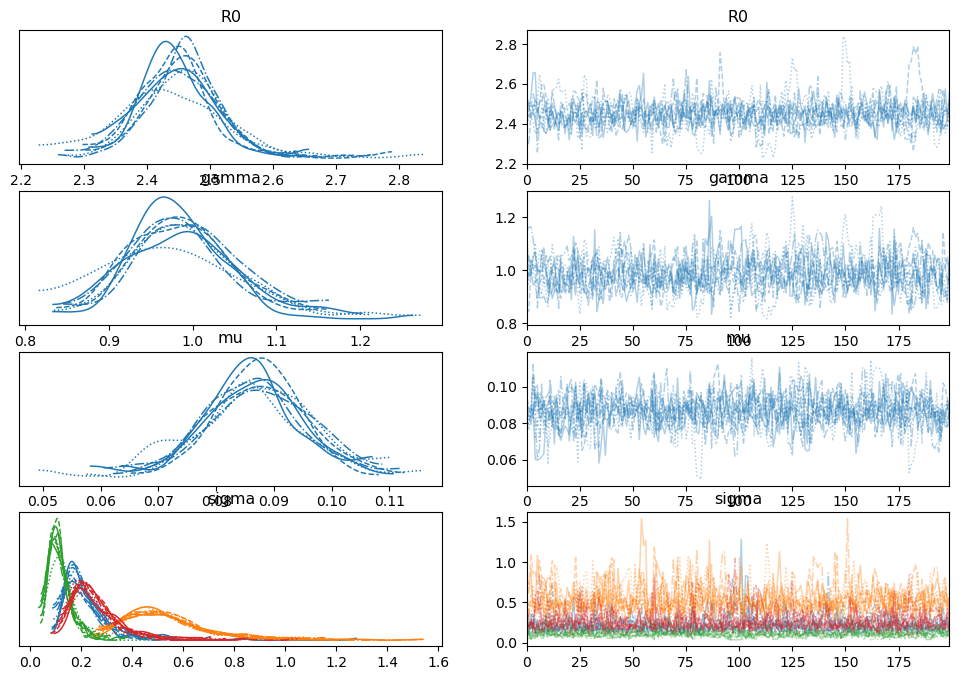

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R0,2.45,0.07,2.32,2.57,0.0,0.0,619.0,703.0,1.02
gamma,0.99,0.07,0.87,1.12,0.0,0.0,535.0,473.0,1.01
mu,0.09,0.01,0.07,0.10,0.0,0.0,810.0,756.0,1.01
sigma[0],0.21,0.09,0.09,0.37,0.0,0.0,1010.0,853.0,1.01
sigma[1],0.53,0.17,0.27,0.86,0.0,0.0,1188.0,1084.0,1.01
sigma[2],0.12,0.05,0.04,0.21,0.0,0.0,820.0,829.0,1.00
sigma[3],0.25,0.10,0.11,0.44,0.0,0.0,1209.0,975.0,1.00


In [2]:
# ODE system container
sird_model = DifferentialEquation(
    func=SIRD,
    times=np.arange(timestep_data, 5 * f, timestep_data),  # start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states=4,  # s(usceptible), i(nfected), r(ecovered), d(eceased)
    n_theta=3,  # beta, gamma, mu
    t0=0  # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:
    # Distribution of variances, sigma[0] to sigma[3], some good choice, pos. chauchy
    sigma = pm.HalfCauchy("sigma", 1, shape=4)

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.TruncatedNormal("R0", 2, 3, lower=1)  # guess of how R0 distribution looks like = Gaussian, mean, lower bound=1: R0>=1
    gamma = pm.TruncatedNormal("gamma", 1, 1, lower=0)
    mu = pm.TruncatedNormal("mu", 0.05, 0.02, lower=0)

    # Our deterministic curves
    sird_curves = sird_model(y0=[1 - i0 - r0 - d0, i0, r0, d0], theta=[R0, gamma, mu])

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal("Y", mu=pm.math.log(sird_curves), sigma=sigma, observed=yobs)  # variances via sigmas, data=yobs

    start = pm.find_MAP()

    step = pm.NUTS()  # pm.Metropolis_Hastings()

    trace = pm.sample(200, step=step, cores=8, random_seed=44)  # set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
az.plot_trace(trace)
plt.show()

# Display summary of the trace
summary = pm.summary(trace).round(2)
summary


## The result
After MCMC we have the R0 =2.4 gamma = 0.99 and mu = 0.087
The orignal value is in the 94% HDI, the parameter estimate is successful.
The sigma 0 to 3 is the parameter describe the measure standard deviation in S, I, R, D.


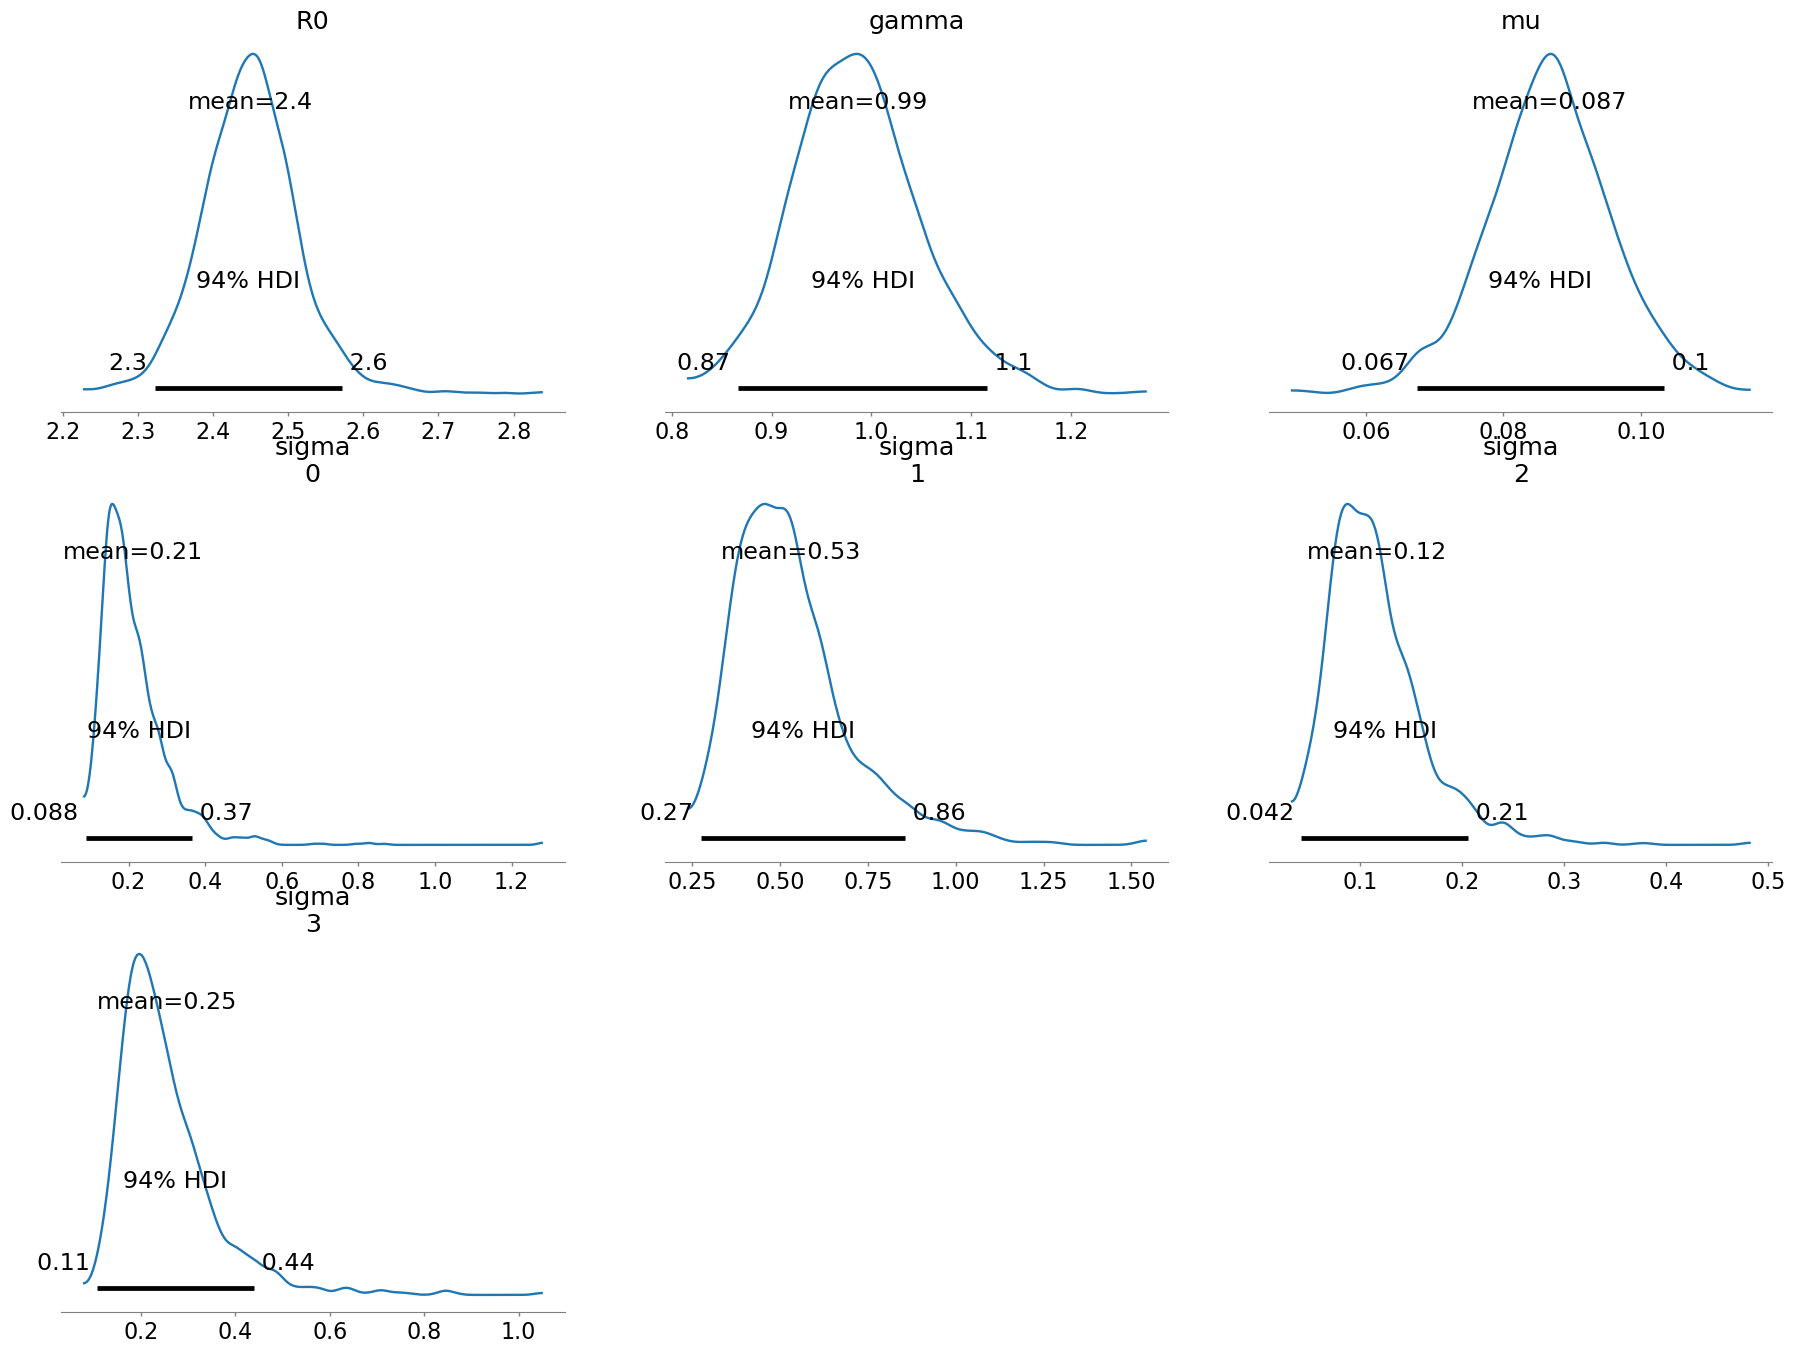

In [6]:
az.plot_posterior(
    trace,
textsize = 16)
#hdi_prob = 0.96)
plt.show()